- [PyQubo](https://qard.is.tohoku.ac.jp/T-Wave/?p=1136)
- [About the instance](https://aws.amazon.com/marketplace/pp/B07T8STKZR?ref_=aws-mp-console-subscription-detail)
- [User Manual](http://dfk66cqpwr4ko.cloudfront.net/user_manual_en_v1_20.pdf)

In [1]:
# !conda install -y attrdict

In [2]:
from collections import defaultdict
import time

import numpy as np
import matplotlib.pyplot as plt
import pickle

import pyqubo

In [3]:
from io import BytesIO
import json
from urllib import request
from urllib.parse import urlencode

import dimod
import scipy.sparse as sp
from scipy.io import mmwrite

class SBMSampler(dimod.Sampler, dimod.Initialized):
    parameters = None
    properties = None

    SCHEME = 'http'
    PATH = 'solver/ising'
    HTTP_HEADERS = {'Content-Type': 'application/octet-stream'}

    def __init__(self, host, port=8000):
        self.host = host
        self.port = port
        self.parameters = {
            'steps': [],
            'loops': [],
            'timeout': [],
            'maxwait': [],
            'target': [],
            'prefer': ['speed', 'auto'],
            'stats': ['none', 'summary', 'full'],
            'dt': [],
            'C': []
        }
        self.properties = {}

    def sample(self, bqm, steps=0, loops=1, timeout=None, maxwait=None, target=None, prefer='auto', stats=None, dt=1.0, C=0):
        biases, offset = bqm.to_qubo()
        keys = list(bqm.variables)
        key2idx = {key:idx for idx, key in enumerate(keys)}
        n_vars = len(keys)

        mat = sp.dok_matrix((n_vars, n_vars))
        for (key1, key2), bias in biases.items():
            row, col = key2idx[key1], key2idx[key2]
            mat[row, col] = bias
            if row != col:
                mat[col, row] = bias

        buff = BytesIO()
        mmwrite(buff, mat, symmetry='symmetric')
        buff.seek(0)
        req_body = buff.read()

        query = urlencode(
            self._delete_if_none(
                dict(steps=steps, loops=loops, timeout=timeout, maxwait=maxwait, target=target, prefer=prefer, stats=stats, dt=dt, C=C)
            )
        )
        url = f'{self.SCHEME}://{self.host}:{self.port}/{self.PATH}?{query}'
        req = request.Request(url, req_body, self.HTTP_HEADERS)

        with request.urlopen(req) as res_:
            res = json.loads(res_.read())

        samples = np.array([res.pop('result')])
        energy = res.pop('value') + bqm.offset

        return dimod.SampleSet.from_samples(
            (samples, keys),
            energy=energy,
            info=res,
            vartype=dimod.SPIN
        )

    def _delete_if_none(self, d):
        return {k:v for k, v in d.items() if v != None}

In [4]:
# utils

def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)


def imshow(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

In [5]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()

In [6]:
def build_model(data, c=10):
    x = pyqubo.Array.create('x', shape=(data.size, data.rows, data.cols), vartype='BINARY')

    costs = []
    sim_max = {'x': 0, 'y': 0}
    for a in range(data.size):
        for b in range(data.size):
            if a == b:
                continue
            sim = {
                'x': sim_x(data.images[a], data.images[b]),
                'y': sim_y(data.images[a], data.images[b])
            }
            sim_max['x'] = max(sim_max['x'], sim['x'])
            sim_max['y'] = max(sim_max['y'], sim['y'])
            for row in range(data.rows):
                for col in range(data.cols):
                    if col < data.cols - 1:
                        costs.append(-sim['x']*x[a, row, col]*x[b, row, col + 1])
                    if row < data.rows - 1:
                        costs.append(-sim['y']*x[a, row, col]*x[b, row + 1, col])


    coeff = c*(sim_max['x'] + sim_max['y'])
    for a in range(data.size):
        costs.append(coeff*pyqubo.Constraint((np.sum(x[a]) - 1)**2, f'img_{a}'))
    for row in range(data.rows):
        for col in range(data.cols):
            costs.append(coeff*pyqubo.Constraint((np.sum(x[:, row, col]) - 1)**2, f'pos_{row}_{col}'))

    return sum(costs).compile(), x

## 問題例

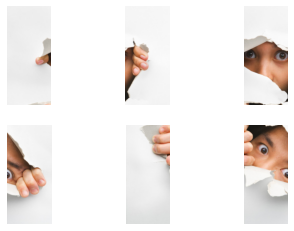

In [7]:
DATA_PATHS = [
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_3.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_5.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_5.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_10.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_10.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_30.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_30.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_50.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_50.pkl',
]

data = load_data(DATA_PATHS[0])
imshow(data.images, data.rows, data.cols)

In [8]:
def is_feasible(sample):
    return all(v[0] for v in sample.constraints().values())

def show_solution(sample, data, x):
    values = np.vectorize(lambda x: sample[x.label])(x)
    pos = np.array(np.where(values == 1)).T
    images = [
        data.images[p[0]]
        for p in sorted(pos, key=lambda x: [x[1], x[2]])
    ]
    imshow(images[:data.size], data.rows, data.cols)

--- data: rows=2, cols=3 ---
	elapsed_time(s)=2.008573293685913
	energy=-2080.0
	is_feasible=True


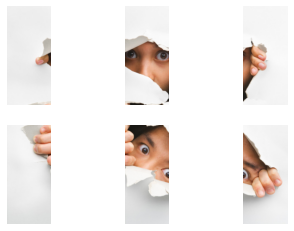

--- data: rows=2, cols=5 ---
	elapsed_time(s)=2.0999410152435303
	energy=23839.0
	is_feasible=False


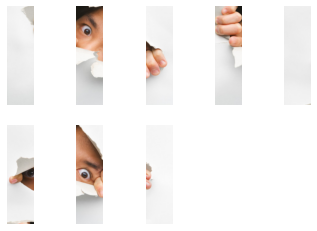

--- data: rows=4, cols=5 ---
	elapsed_time(s)=2.7282040119171143
	energy=150952.0
	is_feasible=False


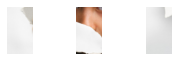

--- data: rows=2, cols=10 ---
	elapsed_time(s)=2.737529754638672
	energy=209275.0
	is_feasible=False


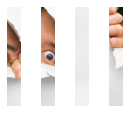

HTTPError: HTTP Error 413: Payload Too Large

In [9]:
SBM_HOST = '18.183.180.85'

for data_path in DATA_PAßTHS:
    data = load_data(data_path)
    model, x = build_model(data)
    bqm = model.to_bqm()
    sampler = SBMSampler(SBM_HOST)
    start = time.time()
    samples = sampler.sample(bqm, loops=1000)
    elapsed_time = time.time() - start
    decoded_samples = model.decode_sampleset(samples)
    best = min(decoded_samples, key=lambda x: x.energy)

    print(f'--- data: rows={data.rows}, cols={data.cols} ---')
    print(f'\telapsed_time(s)={elapsed_time}')
    print(f'\tenergy={best.energy}')
    print(f'\tis_feasible={is_feasible(best)}')

    show_solution(best.sample, data, x)
    plt.show()

    if elapsed_time > 30*60:
        break